# Train Prediction Model

In [25]:
%load_ext watermark
%watermark -v -d -p sklearn,imblearn,pandas,numpy

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Python implementation: CPython
Python version       : 3.10.0
IPython version      : 7.29.0

sklearn : 1.0.1
imblearn: 0.8.1
pandas  : 1.3.4
numpy   : 1.21.4



In [26]:
import pandas as pd
import numpy as np
import seaborn as sns
from imblearn.combine import SMOTETomek
from sklearn.model_selection import train_test_split,cross_val_score,RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import metrics
import pickle

import matplotlib.pyplot as plt
import seaborn as sns
import plothelper as ph
sns.set_context('talk', font_scale=0.9)

import warnings
warnings.filterwarnings("ignore")

In [27]:
dataset=pd.read_csv('./data/diabetes.csv')

X=dataset.drop('outcome', axis=1)
y=dataset['outcome']

In [28]:
X.head()

,pregnancies,glucose,bloodpressure,skinthickness,insulin,bmi,diabetespedigreefunction,age
0,6,148,72,35,30.5,33.6,0.627,50
1,1,85,66,29,30.5,26.6,0.351,31
2,8,183,64,23,30.5,23.3,0.672,32
3,1,89,66,23,94.0,28.1,0.167,21
4,0,137,40,35,168.0,43.1,2.288,33


The `outcome` class is imbalanced:

In [29]:
y.value_counts()

0    500
1    268
Name: outcome, dtype: int64

The problem with imbalanced dataset is, that it creates a **bias**.

### Upsampling

Upsampling is the process of randomly duplicating observations from the minority class in order to reinforce its signal.

In [30]:
smote=SMOTETomek(random_state=42, n_jobs=-1)
X_up, y_up = smote.fit_resample(X, y)
y_up.value_counts()

1    473
0    473
Name: outcome, dtype: int64

## Create Model

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X_up, y_up, test_size=0.25)

rf = RandomForestClassifier(n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1)

### Test Score

In [32]:
score = cross_val_score(rf, X_test, y_test, cv=10, n_jobs=-1)
score

array([0.75      , 0.79166667, 0.875     , 0.91666667, 0.875     ,
       0.70833333, 0.91666667, 0.86956522, 0.91304348, 0.73913043])

In [33]:
score.mean()

0.8355072463768115

### Predictions

In [34]:
print(classification_report(y_test, rf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.83      0.89      0.86       116
           1       0.88      0.83      0.85       121

    accuracy                           0.86       237
   macro avg       0.86      0.86      0.86       237
weighted avg       0.86      0.86      0.86       237



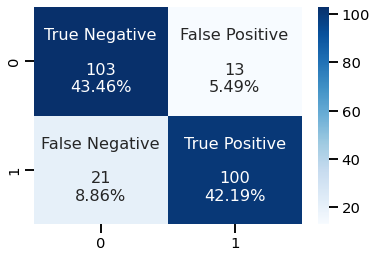

In [35]:
cf_matrix = confusion_matrix(y_test, rf.predict(X_test))
ph.plot_confusion_matrix(cf_matrix)

## Hyperparameter Tuning

In [36]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt', 'log2']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 1000,10)]

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10,14]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4,6,8]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'criterion': ['entropy','gini']
              }

print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth': [10, 120, 230, 340, 450, 560, 670, 780, 890, 1000], 'min_samples_split': [2, 5, 10, 14], 'min_samples_leaf': [1, 2, 4, 6, 8], 'criterion': ['entropy', 'gini']}


In [37]:
rs = RandomizedSearchCV(rf, random_grid, cv=10, verbose=2, n_jobs=-1)
rs.fit(X_train, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


RandomizedSearchCV(cv=10, estimator=RandomForestClassifier(n_jobs=-1),
                   n_jobs=-1,
                   param_distributions={'criterion': ['entropy', 'gini'],
                                        'max_depth': [10, 120, 230, 340, 450,
                                                      560, 670, 780, 890,
                                                      1000],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 4, 6, 8],
                                        'min_samples_split': [2, 5, 10, 14],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   verbose=2)

In [38]:
rs.best_params_

{'n_estimators': 800,
 'min_samples_split': 14,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 890,
 'criterion': 'entropy'}

In [41]:
print(classification_report(y_test, rs.predict(X_test)))

              precision    recall  f1-score   support

           0       0.82      0.87      0.85       116
           1       0.87      0.82      0.84       121

    accuracy                           0.84       237
   macro avg       0.84      0.84      0.84       237
weighted avg       0.85      0.84      0.84       237



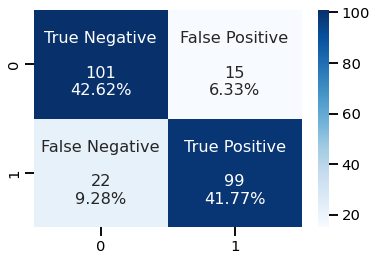

In [43]:
cf_matrix = confusion_matrix(y_test, rs.predict(X_test))
ph.plot_confusion_matrix(cf_matrix)

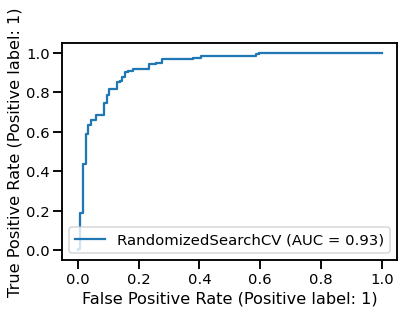

In [44]:
metrics.plot_roc_curve(rs, X_test, y_test);

## Save Model

In [45]:
model_file = open('model/model.pkl', 'wb')
pickle.dump(rs, model_file)
model_file.close()